### Recruitment task for the position of an Trainee Machine Learning Engineer ###
Amazon reviews - data analysis with machine learning and natural language processing elements <br>
Daniel Jankowski <br>
<br>
<br>
Table of contents
1. [Number of selling products depending on the month of the year](#number-of-selling-products-depending-on-the-month-of-the-year)
2. [Which products sell the best?: Product Clustering](#which-products-sell-the-best-and-which-have-the-best-reviews-products-clustering)
3. [Review classification](#review-classification) <br>
    3a. [Examination and analysis of selected data](#examination-and-analysis-of-selected-data)

In [1]:
#import neccesary libraries
#library for reading data from file
import gzip
#common libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
#data visualization libraries
import matplotlib.pyplot as plt
#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
#libraries for data vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#libraries for data pre-processing and NLP
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Modified code from Web Data: Amazon reviews
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.decode('utf8').strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

#create list with dictionaries, from which we will create dataframe
data = []
for e in parse("data\Cell_Phones_&_Accessories.txt.gz"):
  data.append(e)


In [3]:
#read the data as pandas dataframe
df = pd.DataFrame(data)
#rename columns
df.columns = ['productID','product','price','userID','profile','helpfulness','score','date','summary','text']

#Replace all 'unknown' and empty values with None
df = df.replace({'unknown': None, '': None, ' ': None})

#Convert column types
df[['price','score','date']] = df[['price','score','date']].apply(pd.to_numeric)
df['date'] = pd.to_datetime(df['date'], unit='s')
df[['productID','product','userID','profile','helpfulness','summary','text']] = \
    df[['productID','product','userID','profile','helpfulness','summary','text']].astype("string")


### Number of selling products depending on the month of the year ###

In the beginning I decided to conduct a simple and predictable analysis of the number of products sold in each month of the year. As we all probably expect, the sales increases during the Christmas Time, when people usually buy gifts for their family. The only problem, which we actually have to think about is fact that our data consists of customers reviews, not about customer purchases. To simplify, we actually have a date of opinion, not the date of purchase, and as we know, customers can give their feedback a long time after they purchase the product.

However, for the purpose of analysis, we can assume that most of the customers leave their feedback within one to two months of making the purchase. If our assumption is correct, we should clearly see the <b>increases number of reviews given in January or even in February.</b> Those two months are expected as the months, when customers leave their feedback about product, which they had bought during the Christmas Time.


In [4]:
#Create copy of original dataframe
df_sales = df.copy()
#Extract the month from the datatime
df_sales['month'] = df_sales['date'].dt.month

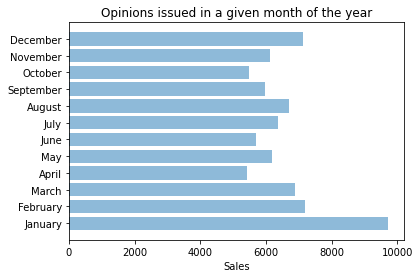

In [14]:
import calendar
#Number of reviews in all months
month_sales = df_sales['month'].value_counts().sort_index()
months = list(calendar.month_name)[1:]

plt.barh(months, month_sales, align='center', alpha=0.5)
plt.xlabel('Sales')
plt.title('Opinions issued in a given month of the year')

plt.show()
# month_sales

As we can see in the above chart our assumption and expectations occurs to be true. There is many more reviews given in January than other months of the year. December is in second place with a slight advantage over February.

These observations allow us to confirm not only that much more purchases are made during the holiday season than in the rest of the year, but also that customers most often leave their opinions within a month of making a purchase.

### Which products sell the best and which have the best reviews?: Products Clustering ###

When runnning online stores, it is very useful to analyze which products are selling the best in order to be able to recommend products to customers more effectively or plan new advertising campaigns.




#### Top 10 products ####

As a warmup analysis I would like to extract from our dataset top 10 products.

In [241]:
#Copy of original df
df_products = df.copy()
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   productID    78930 non-null  string        
 1   product      78383 non-null  string        
 2   price        35643 non-null  float64       
 3   userID       76654 non-null  string        
 4   profile      76654 non-null  string        
 5   helpfulness  78930 non-null  string        
 6   score        78930 non-null  float64       
 7   date         78930 non-null  datetime64[ns]
 8   summary      78928 non-null  string        
 9   text         78930 non-null  string        
dtypes: datetime64[ns](1), float64(2), string(7)
memory usage: 6.0 MB


There is one row where `productID` is `None`, so we won't take that row into account. Moreover, some of the rows have a `None` value in `product` attribute. We can check whether we are able to fill some of these missing values.

In [226]:
#Omit one row with None productID
df_products = df_products[df_products['productID'].notna()]
#Check if one product has different values in its name field, i.e. proper name and None value
df_products.groupby('productID')['product'].nunique(dropna=False).sort_values(ascending=False)


productID
1588465934    1
B000ID1G0W    1
B000IEFILY    1
B000IEDH9E    1
B000IED9GA    1
             ..
B000AAYEZC    1
B000AATKBA    1
B000AANVAG    1
B000AALYOG    1
B000UUEH04    1
Name: product, Length: 7438, dtype: int64

All of the products have maximum one unique `product` attribute value. Therefore, each of the product have either a proper filled name or have a `None` value. Unfortunately, we are not able to fill any missing values of `product` attribute in that case. 

In [233]:
#Compute frequency of reviewing products with their score mean
prod_rank = df_products.groupby('productID').agg({'userID':'size', 'score':'mean'}) \
    .rename(columns={'userID':'product_frequency','score':'mean_score'}) \
        .reset_index()

In [228]:
top_products = prod_rank[prod_rank['mean_score'] >= 4.0] \
    .sort_values(by='product_frequency', ascending=False)\
        .head(10)
top_products


,productID,product_frequency,mean_score
2216,B0009B0IX4,3443,4.161778
7244,B000Q6R4MK,515,4.058252
1912,B0007N08NO,344,4.380814
686,B00009J5VV,302,4.006623
5153,B000J2FOF0,190,4.068421
3854,B000FL9QGI,184,4.250000
3674,B000F9LRYO,163,4.110429
6896,B000PB8CQI,145,4.613793
4900,B000I8FL0S,138,4.347826
5835,B000LGE1LW,137,4.343066


As a selection criterion of the best products I decided to base most on the number of reviews. As we don't want to make a very bad product with `mean_score` = 1.0 at the top, another criterion was that the item has to have the `mean_score` >= 4.0. Finally we get the list of 10 the best selling products with score above or equal to 4.0.

Since the `productID` tells us little, below there is a table with products name instead of ID's.

In [240]:
prod_ids = top_products['productID'].to_numpy()
top_prod_names = df_products[df_products['productID'].isin(prod_ids)][['productID','product']]
pd.merge(top_prod_names.drop_duplicates(), top_products, on='productID')\
    .sort_values(by='product_frequency', ascending=False)

,productID,product,product_frequency,mean_score
3,B0009B0IX4,Plantronics Voyager 510 Bluetooth Headset [Ret...,3443,4.161778
1,B000Q6R4MK,BlueAnt Supertooth Light Bluetooth Speakerphon...,515,4.058252
2,B0007N08NO,Motorola Cigarette Lighter Adapter for Motorol...,344,4.380814
7,B00009J5VV,<NA>,302,4.006623
9,B000J2FOF0,"Sony Ericsson W810i Phone (AT&T, Phone Only, N...",190,4.068421
8,B000FL9QGI,BlueAnt Bluetooth Portable Handsfree Supertoot...,184,4.250000
4,B000F9LRYO,"Belkin TuneTalk Stereo for iPod 5G, 5.5G (Black)",163,4.110429
5,B000PB8CQI,Multi-Use Vehicle Charger with Dual USB Ports ...,145,4.613793
0,B000I8FL0S,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,138,4.347826
6,B000LGE1LW,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,137,4.343066


Creating such a rankings is always very exciting thing to do, but to be honest they are not really helpful. Let's say that we would like to somehow categorize our products and base on that, select the best products from each category. It's much better solution, because we would be able to recommend product from category, in which customers are looking for.

Since our data doesn't provide any categories of products, clustering techniques seems very good in that case. 



#### Products clustering ####

Scope of this section:
1. Text preprocessing
2. Vectorization of our data
3. Implementation of choosen clustering algorithm
4. Observations and analysis of results

Since the problem is to cluster the products, now we will more focus on the products name rather than theirs ID's.


In [4]:
#load original data just in case
df_products = df.copy()
#since we work on products name, we have drop all the rows with None value in product field
df_products = df_products[df_products['product'].notna()]['product']
df_products.head()

0    Mobile Action MA730 Handset Manager - Bluetoot...
1    Mobile Action MA730 Handset Manager - Bluetoot...
2    Mobile Action MA730 Handset Manager - Bluetoot...
3    USB Data Cable for Sony-Ericsson Z600, Z500, Z...
4    USB Data Cable for Sony-Ericsson Z600, Z500, Z...
Name: product, dtype: string

##### Text preprocessing #####

In [5]:
#function, which will clean the data from punctuations, digits and other invalid characters. 
def preprocess(text):
    text = text.lower() 
    text = re.sub(r'\d+', '', text)
    text = ''.join([i for i in text if i not in string.punctuation])
    text = text.strip()
    return word_tokenize(text)

to_remove = stopwords.words('english')

#function which will remove from given review all stopwords, which occurs in english language (words like 'in','he,'where','when' etc.).
def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

#function which will perform lemmatization of words in given review, i.e. convert different forms of one word into one form,
#so they can be analysis as single word 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)

In [6]:
df_products = df_products.apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
df_products.head()
#TODO: delete from data companies names, colors etc. 

0    action bluetooth data handset manager mobile s...
1    action bluetooth data handset manager mobile s...
2    action bluetooth data handset manager mobile s...
3    cable cd data driver internet k p r sonyericss...
4    cable cd data driver internet k p r sonyericss...
Name: product, dtype: object

##### Data vectorization #####

In [7]:
#TODO: think about vectorizer parameters
#create the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95)
#apply TD-IDF to the data
X = vectorizer.fit_transform(df_products)

<78383x4026 sparse matrix of type '<class 'numpy.float64'>'
	with 561355 stored elements in Compressed Sparse Row format>

##### Building Clustering model #####

One of the important aspects in case of clustering data is to get optimal number of clusters. In my solution I decided to use `The elbow curve method`. 

In [8]:
#TODO: once again run KMeans with K in (3,13)
avg_distances = []
K = range(3,13)
for n_clusters in K:
    model = KMeans(n_clusters=n_clusters, random_state=12)
    model.fit(X)
    print(n_clusters)
    avg_distances.append(model.inertia_)

1
2
3
4
5
6
7
8
9


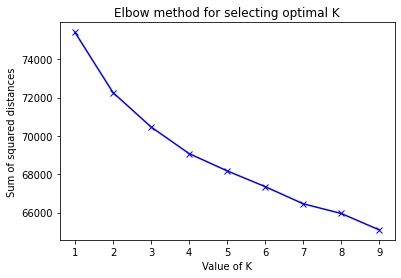

In [9]:
plt.plot(K, avg_distances, 'bx-')
plt.xlabel("Value of K")
plt.ylabel("Sum of squared distances")
plt.title("Elbow method for selecting optimal K")
plt.show()

In [10]:
clusters = model.labels_

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=12)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:,0]
x1 = pca_vecs[:,1]

In [13]:
df_products['cluster'] = clusters
df_products['x0'] = x0
df_products['x1'] = x1

In [15]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
blackberry,mm,nokia,headset,leather,black,motorola,charger,phone,case

Cluster 1
get,black,silver,motorola,headset,bluetooth,plantronics,voyager,retail,packaging

Cluster 2
vx,retractable,motorola,wall,phone,mini,charger,data,cable,usb

Cluster 3
playerinternational,mp,cell,phone,player,mpvideo,camera,unlocked,warranty,version

Cluster 4
vx,retail,samsung,headset,wep,phone,bluetooth,black,verizon,wireless

Cluster 5
grey,discovery,stereo,bt,plantronics,black,jabra,motorola,headset,bluetooth

Cluster 6
headset,drbt,att,stereo,tmobile,za,wi,phone,ericsson,sony

Cluster 7
black,nokia,postpaid,nextel,razr,samsung,motorola,att,tmobile,phone

Cluster 8
snn,vi,vc,lithiumion,standard,br,motorola,liion,oem,battery


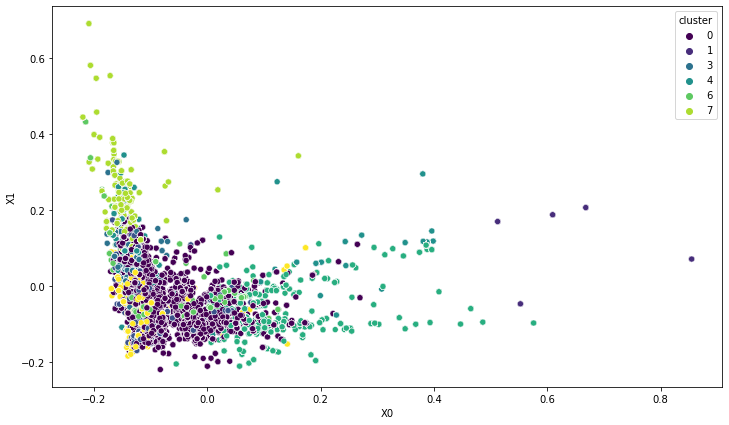

In [17]:
import seaborn as sns
plt.figure(figsize=(12,7))
plt.xlabel("X0")
plt.ylabel("X1")
sns.scatterplot(data=df_products, x='x0', y='x1', hue='cluster', palette='viridis')
plt.show()

### Best Customers ###

The idea is to find through set of all reviews customers with the best helpfulness ratio. 

In [34]:
df_customers = df.copy()
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   productID    78930 non-null  string        
 1   product      78383 non-null  string        
 2   price        35643 non-null  float64       
 3   userID       76654 non-null  string        
 4   profile      76654 non-null  string        
 5   helpfulness  78930 non-null  string        
 6   score        78930 non-null  float64       
 7   date         78930 non-null  datetime64[ns]
 8   summary      78928 non-null  string        
 9   text         78930 non-null  string        
dtypes: datetime64[ns](1), float64(2), string(7)
memory usage: 6.0 MB


In [35]:
df_customers.head()

,productID,product,price,userID,profile,helpfulness,score,date,summary,text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,2009-01-31,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,2007-10-04,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,2007-08-10,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,2006-04-28,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,2007-03-12,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


In [36]:
df_customers = df_customers[df_customers['userID'].notna()]\
    [['userID','helpfulness','score','summary','text']]


In [37]:
df_customers[['positive_help','all_help']] = df_customers.helpfulness.str.split('/', expand=True)

In [38]:
df_customers[['positive_help','all_help']] = df_customers[['positive_help','all_help']].apply(pd.to_numeric)
df_customers['fraction_help'] = df_customers['positive_help']/df_customers['all_help']

In [39]:
df_customers = df_customers[['userID','fraction_help']]
df_customers.head()

,userID,fraction_help
0,A1RXYH9ROBAKEZ,NaN
1,A7L6E1KSJTAJ6,NaN
2,A2NOQQ7I6PU7CW,NaN
3,A29Q0CLOF0U8BN,0.8
4,ANNHJND2MHUI3,NaN


In [40]:
df_customers['fraction_help'] = df_customers['fraction_help'].fillna(0)


In [41]:
df_customers.sort_values(by='fraction_help', ascending=False)

,userID,fraction_help
51944,A1O3638QX3SEXH,1.0
70160,A2HE5A5CSB5JTI,1.0
59585,ACRZLT0AZ5WNR,1.0
36606,A1CQRZDRLK8CUB,1.0
36607,A27CQ4V6YYVC3G,1.0
...,...,...
34170,A2SMF4FRC07R99,0.0
34171,AG86HEK3BBOYK,0.0
34172,A30E7AJGZK0XNM,0.0
34173,A198T2U3P8VASO,0.0


### Review classification ###

As a first thing, I decided to build simply review classification. I would like to create the model, which based on text review will clasify the user opinion as <i>positive</i> or <i>negative</i>.

#### Examination and analysis of selected data ####

In [4]:
#I create copy of dataframe to keep the original data intact.
df_copy = df.copy()

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

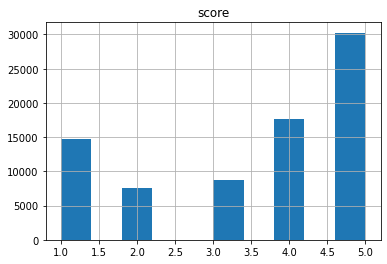

In [7]:
#very intuitive plot of scores distribution of all products
df_copy.hist(column='score')

The data clearly shows that there is the most reviews with score $5.0$, what is quite interesting, but very positive information. In fact, when a customer is satisfied with their purchase, they will not always leave a positive opinion. The other way around, the situation is completely different. Most of customers, who are not satisfied with their purchase, will almost always leave a negative opinion. Therefore based on given data, we can claimed that most of the selling products are of good quality.

There is no such a surprise, that reviews with score $2.0$ and $3.0$ are the least frequent in the data. This is because of the fact, that most of the people treat their purchased product in binary way, i.e. when everything works fine, in most cases customers will rate the product with the highest possible score. The same happens the other way around when the customer is in any way dissatisfied with the purchase, much more often he will give the lowest possible rating.

<b>Therefore based on that observations, I decided to divide all reviews into two groups, such that all reviews with $score >= 4.0$ will be treated as positive opinions and all other will be label as negative one.</b>

In [8]:
#select from dataframe review text and label it based on score
df_copy['label'] = np.where(df_copy['score'] > 3.0, 1, 0)
#from main dataframe we select only text and label column, other columns are not needed for us
reviews = df_copy[['text','label']]
reviews.style.set_properties(subset=['text'], **{'width': '300px'})
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78931 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 925.1 KB


In [9]:
#we have one example, when text attribute is null, therefore we delete it
reviews.dropna(subset=['text'], inplace=True)
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78930 entries, 0 to 78929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78930 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 1.5 MB


positive examples: 60.78%
negative examples: 39.22%


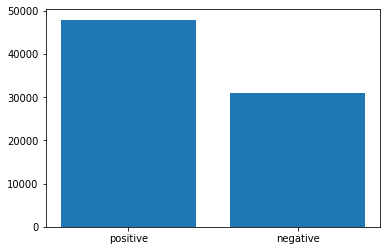

In [10]:
#Count examples of both groups
x = reviews['label'].value_counts()
plt.bar(['positive','negative'], x)
print("positive examples: {:2.2%}".format(x[1]/len(reviews)))
print("negative examples: {:2.2%}".format(x[0]/len(reviews)))

Based on previous observations, there is no thunderbolt that positive opinions are more frequent. Nevertheless, those two groups are quite balanced, therefore there is no need to carry out any data balancing techniques.

#### Pre-processing data ####

Important thing in case of working with text data is to preprocess it. It would make our data more clear and in result the model will be more efficient.

In [11]:
#function, which will clean the data from punctuations, digits and other invalid characters. 
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text.split()

to_remove = stopwords.words('english')

#function which will remove from given review all stopwords, which occurs in english language (words like 'in','he,'where','when' etc.).
def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

#function which will perform lemmatization of words in given review, i.e. convert different forms of one word into one form,
#so they can be analysis as single word 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)
    

In [12]:
#perform preprocessing
reviews['text'] = reviews['text'].apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
reviews.head()


,text,label
0,actually advice another back buy company custo...,0
1,buy cell compared data definite easily easy gr...,1
2,advertised doesnt go good handset hard little ...,1
3,amazon around benefit better big button c cabl...,1
4,buy cable charger data dont usb,0


#### Vectorize data and split it into training and test sets ####



In [13]:
#Create vectorizer, max_features=1500 means that we will take into account only the most 1500 frequent words from our vocabulary
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(reviews['text']).toarray()

In [14]:
#Split our data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, reviews['label'],\
    test_size = 0.2, random_state=12)

#### Building ML model ####

As a first model I would like to try LinearSVC, since its performance in case of text classification is usually very satisficated.

In [16]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(dual=False)
classifier.fit(X_train, y_train)

LinearSVC(dual=False)

In [17]:
#Testing our model
y_predict = classifier.predict(X_test)
y_prob = classifier._predict_proba_lr(X_test)[:,1]

In [22]:
#evaluate the model
print(classification_report(y_test,y_predict)) 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6190
           1       0.83      0.88      0.85      9596

    accuracy                           0.82     15786
   macro avg       0.81      0.80      0.81     15786
weighted avg       0.82      0.82      0.82     15786

AUC: 0.8890387149734575


|          | Positive | Negative |
|----------|----------|----------|
| Positive | TP=4460  | FP=1730  |
| Negative | FN=1139  | TN=8457  |

$Precision = TP/(TP+FP)$ <br>
$Recall = TP/(TP+FN)$